In [104]:
### autoreload
%reload_ext autoreload
%autoreload 2

### import
# general
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# plotting
import matplotlib.pyplot as plt
import seaborn as sns 

# custom
from calcification import analysis, utils, plotting, config, processing

In [105]:
### process raw data
carbonate_df = processing.populate_carbonate_chemistry(
    fp=config.data_dir / 'Orlando_data.xlsx',
    sheet_name='bioerosion',
    selection_dict={'include': 'yes'})
print(f"\nShape of dataframe with all rows marked for inclusion: {carbonate_df.shape}")

Using locations in /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/resources/gmaps_locations.yaml
Using species mapping in /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/resources/species_mapping.yaml
Loading measured values...


Calculating carbonate chemistry:   0%|          | 0/91 [00:00<?, ?it/s]


Shape of dataframe with all rows marked for inclusion: (91, 82)


In [146]:
### basic processing to get ready for assigning effect sizes
# assign treatment groups
carbonate_df_tgs = processing.assign_treatment_groups_multilevel(carbonate_df)
print(f"\nShape of dataframe with treatment groups: {carbonate_df_tgs.shape}")
n1_rows = len(carbonate_df_tgs[carbonate_df_tgs['n'] == 1])
# grouping any samples with samples of n=1
carbonate_df_tgs_no_ones = processing.aggregate_treatments_with_individual_samples(carbonate_df_tgs)
print(f"\nShape of dataframe with treatment groups and grouped n=1 rows: {carbonate_df_tgs_no_ones.shape}. \nOriginal had {n1_rows} n=1 rows.")
working_df = carbonate_df_tgs_no_ones.copy()

Assigning treatment groups:   0%|          | 0/21 [00:00<?, ?it/s]


Shape of dataframe with treatment groups: (91, 87)

Shape of dataframe with treatment groups and grouped n=1 rows: (86, 87). 
Original had 5 n=1 rows.


In [107]:
### data summary
# number of studies
print(f'Number of studies: {len(working_df["original_doi"].unique())}')
# number of distinct locations
print(f'Number of distinct named locations: {len(working_df["location"].unique())}')
print(f'Number of distinct locations (by coordinate pair): {working_df.groupby(['latitude', 'longitude']).ngroups}')
print(f'Number of visits to a unique location (e.g. including times when studies have used the same location): {working_df.doi.nunique()}')

### I'm waiting on judgement re some, to revisit other to extract additional/correct data
check_waiting_df = pd.read_excel(
    config.data_dir / 'Orlando_data.xlsx',
    sheet_name='bioerosion',
)

# Filter first, then group and count
filtered = check_waiting_df[check_waiting_df['Include'].isin(['revisit', 'check'])]
count_per_doi = filtered.groupby('DOI').size()
print(f'Number of studies marked as "revisit" or "check": {len(count_per_doi)} corresponding to {len(filtered)} rows.')

# for bioerosion, assign taxa values to core_grouping column
working_df['core_grouping'] = working_df['taxa'] 

Number of studies: 15
Number of distinct named locations: 13
Number of distinct locations (by coordinate pair): 11
Number of visits to a unique location (e.g. including times when studies have used the same location): 19
Number of studies marked as "revisit" or "check": 1 corresponding to 8 rows.


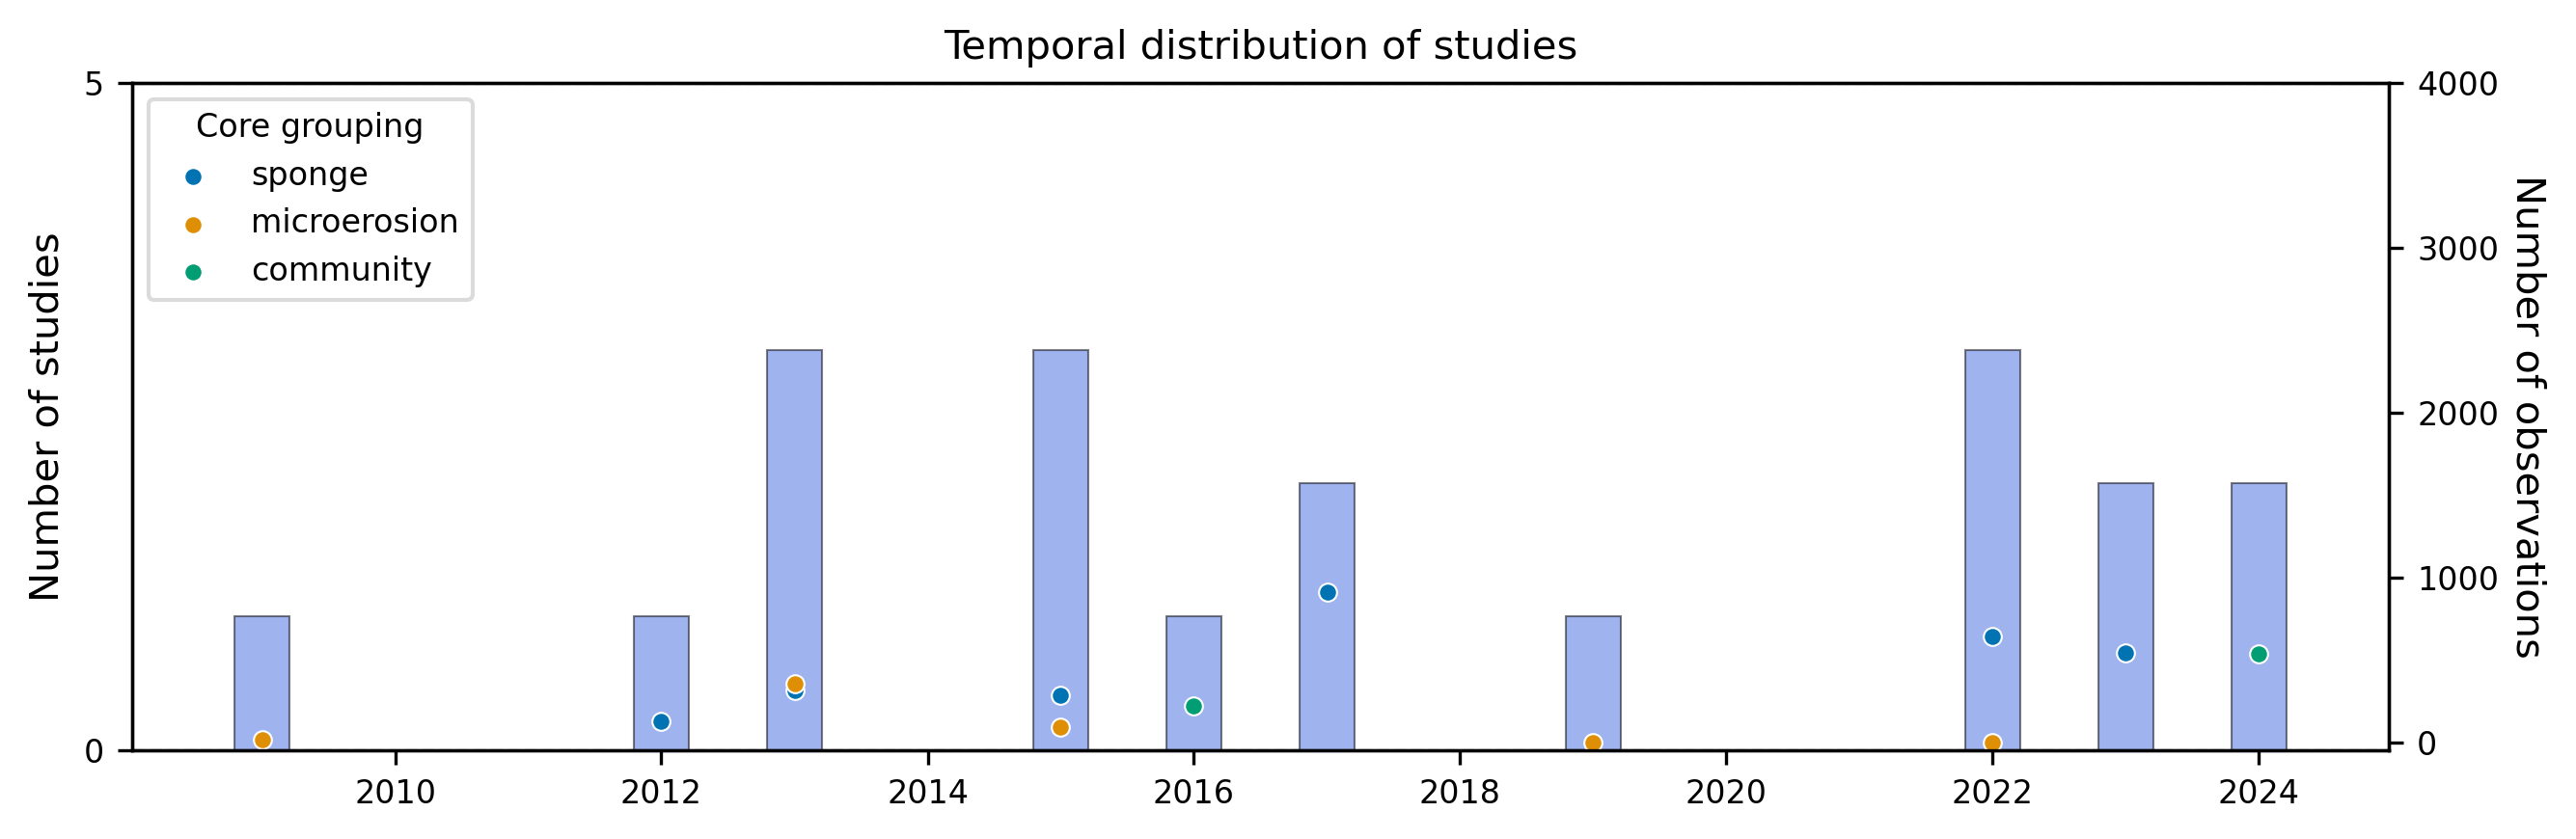

In [108]:
### plot temporal distribution of studies, broken down by species
plotting.plot_study_timeseries(working_df, colorby='core_grouping');

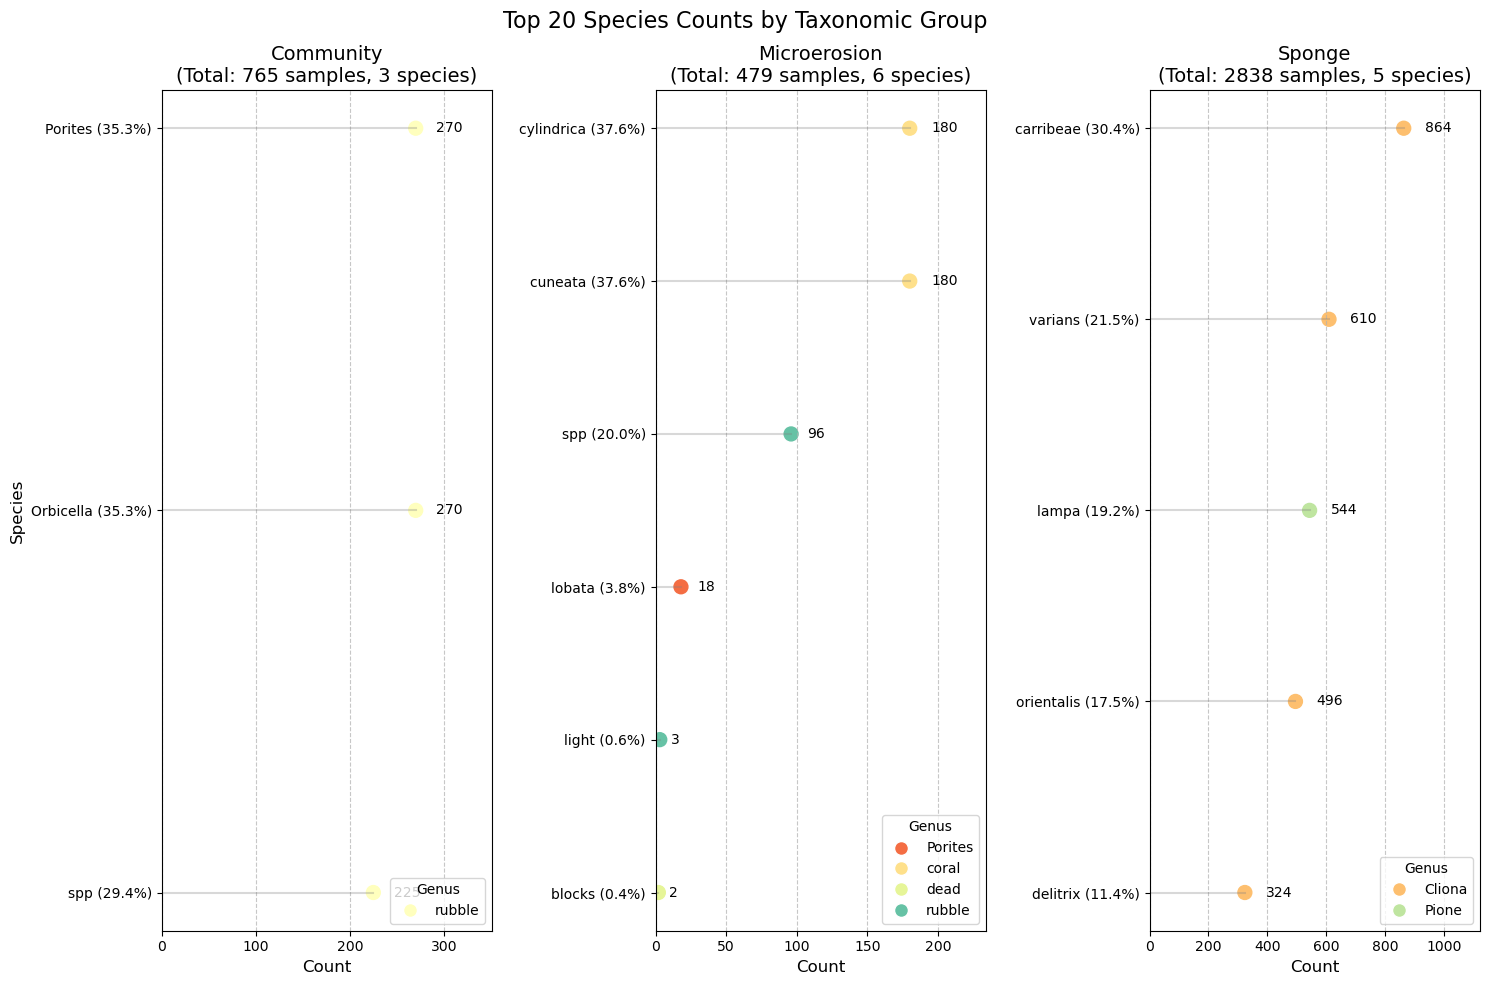

In [109]:
### plot taxonomic distribution of study organisms (
plotting.create_faceted_dotplot_with_percentages(working_df, top_n=20);

## Units

Number of different calcification units: 4


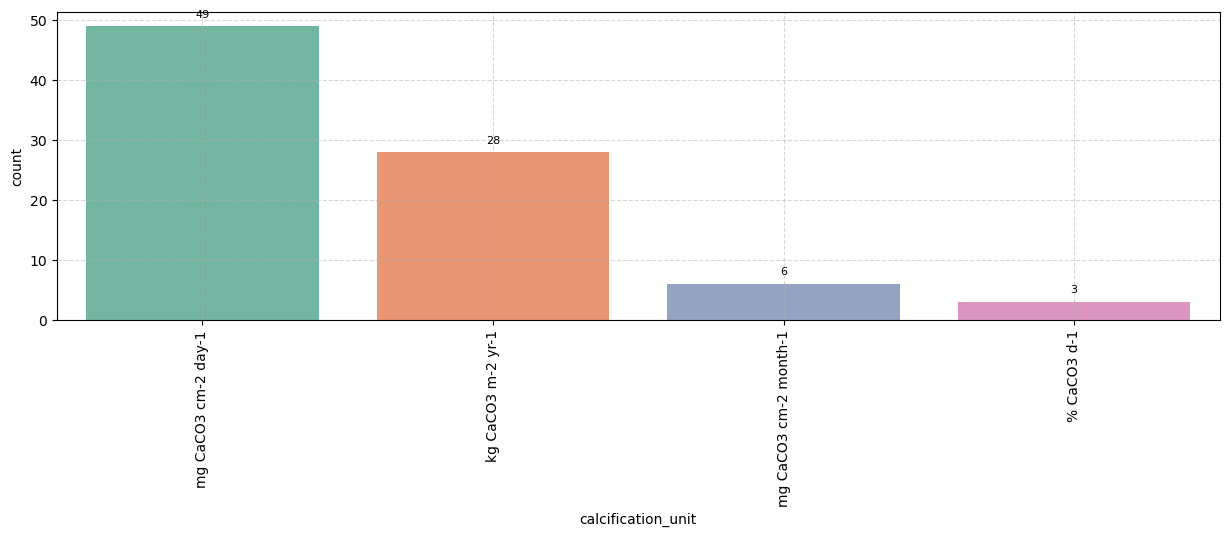

In [110]:
### raw units
plt.figure(figsize=(15, 4))
count_order = working_df['calcification_unit'].value_counts().index # sort by number of counts for each calcification unit
sns.countplot(data=working_df, x='calcification_unit', order=count_order, palette='Set2', hue='calcification_unit')
plt.xticks(rotation=90)
plt.grid(ls='--', alpha=0.5)
for p in plt.gca().patches:
    plt.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=8, color='black', xytext=(0, 5), textcoords='offset points')
print(f'Number of different calcification units: {len(working_df["calcification_unit"].unique())}')

Number of distinct types of calcification measurement: 2


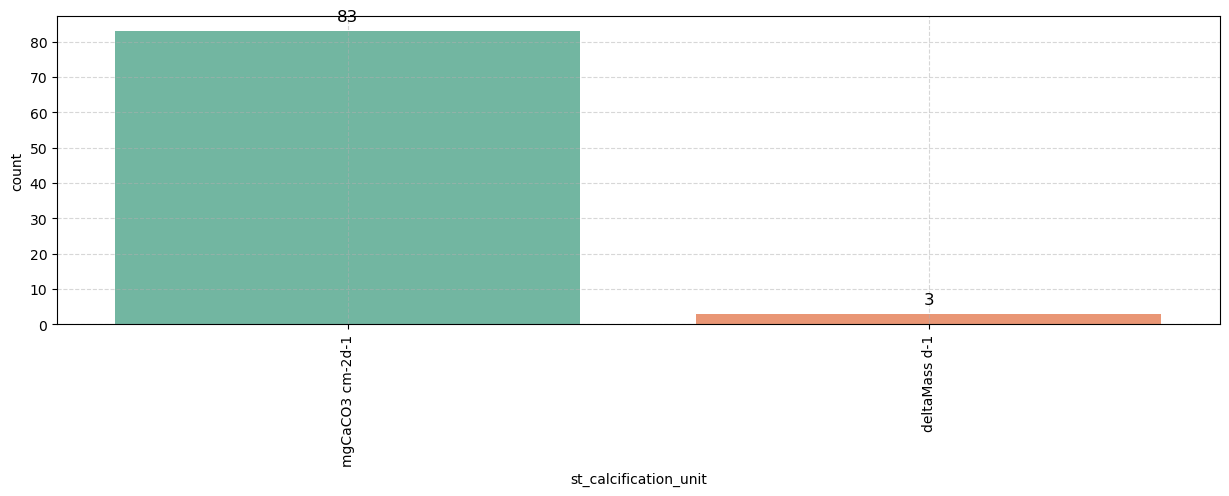

In [111]:
### standardised units
plt.figure(figsize=(15, 4))
count_order = working_df['st_calcification_unit'].value_counts().index # sort by number of counts for each calcification unit
sns.countplot(data=working_df, x='st_calcification_unit', order=count_order, palette='Set2', hue='st_calcification_unit')
plt.xticks(rotation=90);
plt.grid(ls='--', alpha=0.5)
# plot numbers at the top of the bars
for p in plt.gca().patches:
    plt.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')
print(f'Number of distinct types of calcification measurement: {len(working_df["st_calcification_unit"].unique())}')

Number of distinct types of calcification measurement: 2


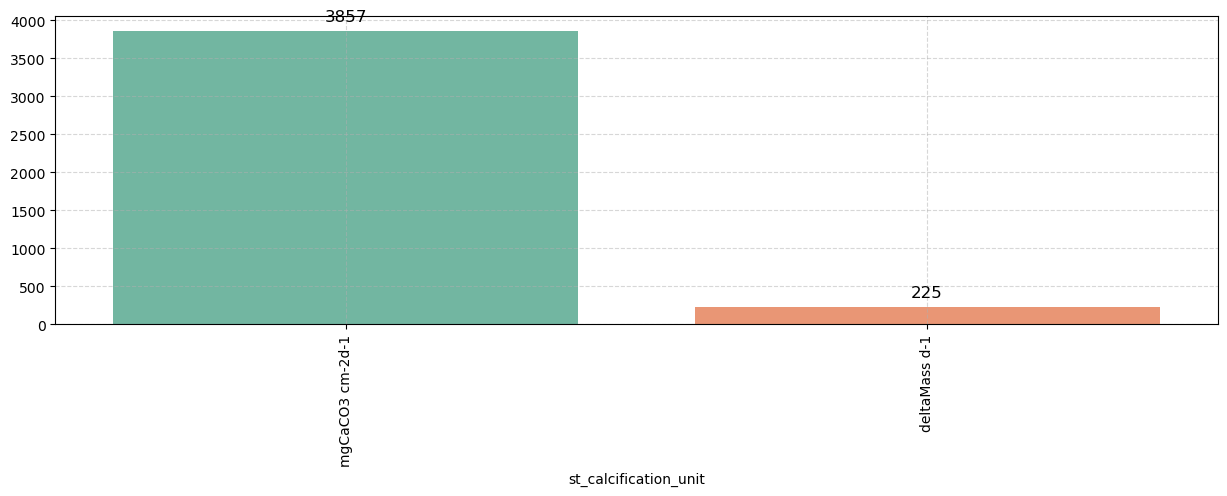

In [112]:
### standardised units with total samples (n)
plt.figure(figsize=(15, 4))

# Group by 'st_calcification_unit' and sum the 'n' column
unit_counts = working_df.groupby('st_calcification_unit')['n'].sum().sort_values(ascending=False)

# Plot the data
sns.barplot(x=unit_counts.index, y=unit_counts.values, palette='Set2', hue=unit_counts.index)
plt.xticks(rotation=90)
plt.grid(ls='--', alpha=0.5)

# Annotate the bars with the total counts
for i, value in enumerate(unit_counts.values):
    plt.annotate(f'{int(value)}', (i, value), ha='center', va='bottom', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

print(f'Number of distinct types of calcification measurement: {len(unit_counts)}')

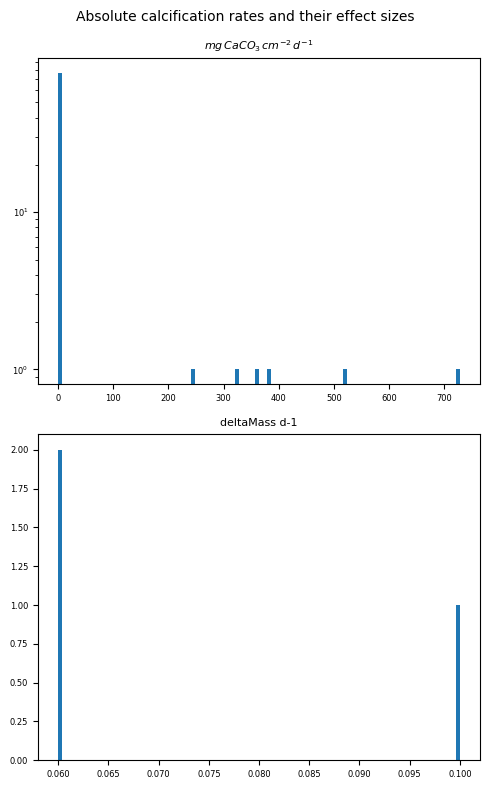

In [113]:
# TODO: check this conversion rate
### visualise distributions of various calcification rates
rate_type_mapping = {
    'mgCaCO3 cm-2d-1': r'$mg \, CaCO_3 \, cm^{-2} \, d^{-1}$',
    'mgCaCO3 g-1d-1': r'$mg \, CaCO_3 \, g^{-1} \, d^{-1}$',
    'delta mass d-1': r'$\Delta mass\, d^{-1}$',
    'mg d-1': r'$mg \, d^{-1}$',
    'm2 d-1': r'$m^2 \, d^{-1}$',
    'm d-1': r'$m \, d^{-1}$',
    'deltaSA d-1': r'$\Delta SA \, d^{-1}$'
}

rate_types = working_df['st_calcification_unit'].unique()
rate_types = [rate_type for rate_type in rate_types if rate_type != ""]
fig, axes = plt.subplots(len(rate_types), 1, figsize=(5, 8), dpi=100)

for i, rate_type in enumerate(rate_types):
    # absolute calcification
    axes[i].hist(working_df[working_df['st_calcification_unit'] == rate_type]['st_calcification'], bins=100)
    axes[i].set_title(f"{rate_type_mapping.get(rate_type, rate_type)}", fontsize=8)
    
# format
for ax in axes.flatten():
    if max([p.get_height() for p in ax.patches]) > 10:
        ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=6)  # Adjust label size for both axes
    
plt.suptitle('Absolute calcification rates and their effect sizes', fontsize=10)
plt.tight_layout()

# WAITING ON CLIMATOLOGY FROM BEN

In [114]:
# TODO: fix these figures
missing_coords = working_df[working_df.latitude.isna() | working_df.longitude.isna()]
print(f"Number of rows without lat/lon coordinates: {len(missing_coords)}.")
print(f"These correspond to the following locations: {missing_coords.drop_duplicates('doi', keep='first').location.values}.")

aquaria_locations = working_df[working_df['location'].str.lower().str.contains('aquar', na=False)]
additional_rows = set(aquaria_locations.drop_duplicates('doi', keep='first').location.values) - set(missing_coords.drop_duplicates('doi', keep='first').location.values)
print(f'In addition, the following are aquaria with location information: {list(additional_rows)}.')
print(f'...corresponding to {len(aquaria_locations) - len(missing_coords)} additional rows.')
print(f'This makes {len(missing_coords) + len(additional_rows)} rows with spurious or missing location information.')

Number of rows without lat/lon coordinates: 0.
These correspond to the following locations: [].
In addition, the following are aquaria with location information: [].
...corresponding to 0 additional rows.
This makes 0 rows with spurious or missing location information.


In [115]:
### load climatology data
ph_climatology = processing.convert_climatology_csv_to_multiindex(
    config.climatology_data_dir / "ph_scenarios_output_table_site_locations.csv",
    config.resources_dir / 'locations.yaml')

sst_climatology = processing.convert_climatology_csv_to_multiindex(
    config.climatology_data_dir / "sst_scenarios_output_table_site_locations.csv",
    config.resources_dir / 'locations.yaml')

# concatenated sst and ph climatology dataframes
merged_clim_df = pd.merge(
    sst_climatology,
    ph_climatology,
)

# set multiindex
merged_clim_df_mi = merged_clim_df.set_index(['doi', 'location', 'longitude', 'latitude'])

working_df_mi = working_df.set_index(['doi', 'location', 'longitude', 'latitude'])

### NOT READY TO MERGE SINCE DON'T HAVE THE DATA FOR THESE SPECIFIC LOCATIONS – COULD INTERPOLATE IT
# working_clim_df = working_df_mi.join(merged_clim_df_mi, how='inner')

# print(f"There are {len(merged_clim_df_mi.index.unique())} unique locations in the climatology data compared with {len(working_df.drop_duplicates('doi', keep='first'))} location counts in the working dataframe.")

# # exclude locations mentioning Monaco or Portugal from climatology data
# working_clim_df = working_clim_df[~working_clim_df.index.get_level_values('location').str.contains('monaco|portugal', case=False, na=False)]

/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/calcification/processing.py:488: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(
/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/calcification/processing.py:488: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(


In [116]:
### calculate the global average anomalies for each scenario and time_frame
future_global_anomaly_df = merged_clim_df_mi.reset_index().groupby(['scenario', 'time_frame']).agg(
    mean_sst_anomaly=('mean_sst_20y_anomaly_ensemble', 'mean'),
    mean_ph_anomaly=('mean_ph_20y_anomaly_ensemble', 'mean'),
).reset_index()
future_global_anomaly_df.head()

,scenario,time_frame,mean_sst_anomaly,mean_ph_anomaly
0,ssp126,2030,0.772673,-0.065136
1,ssp126,2050,1.042705,-0.090569
2,ssp126,2090,1.160536,-0.085533
3,ssp245,2030,0.766957,-0.068939
4,ssp245,2050,1.216830,-0.116366


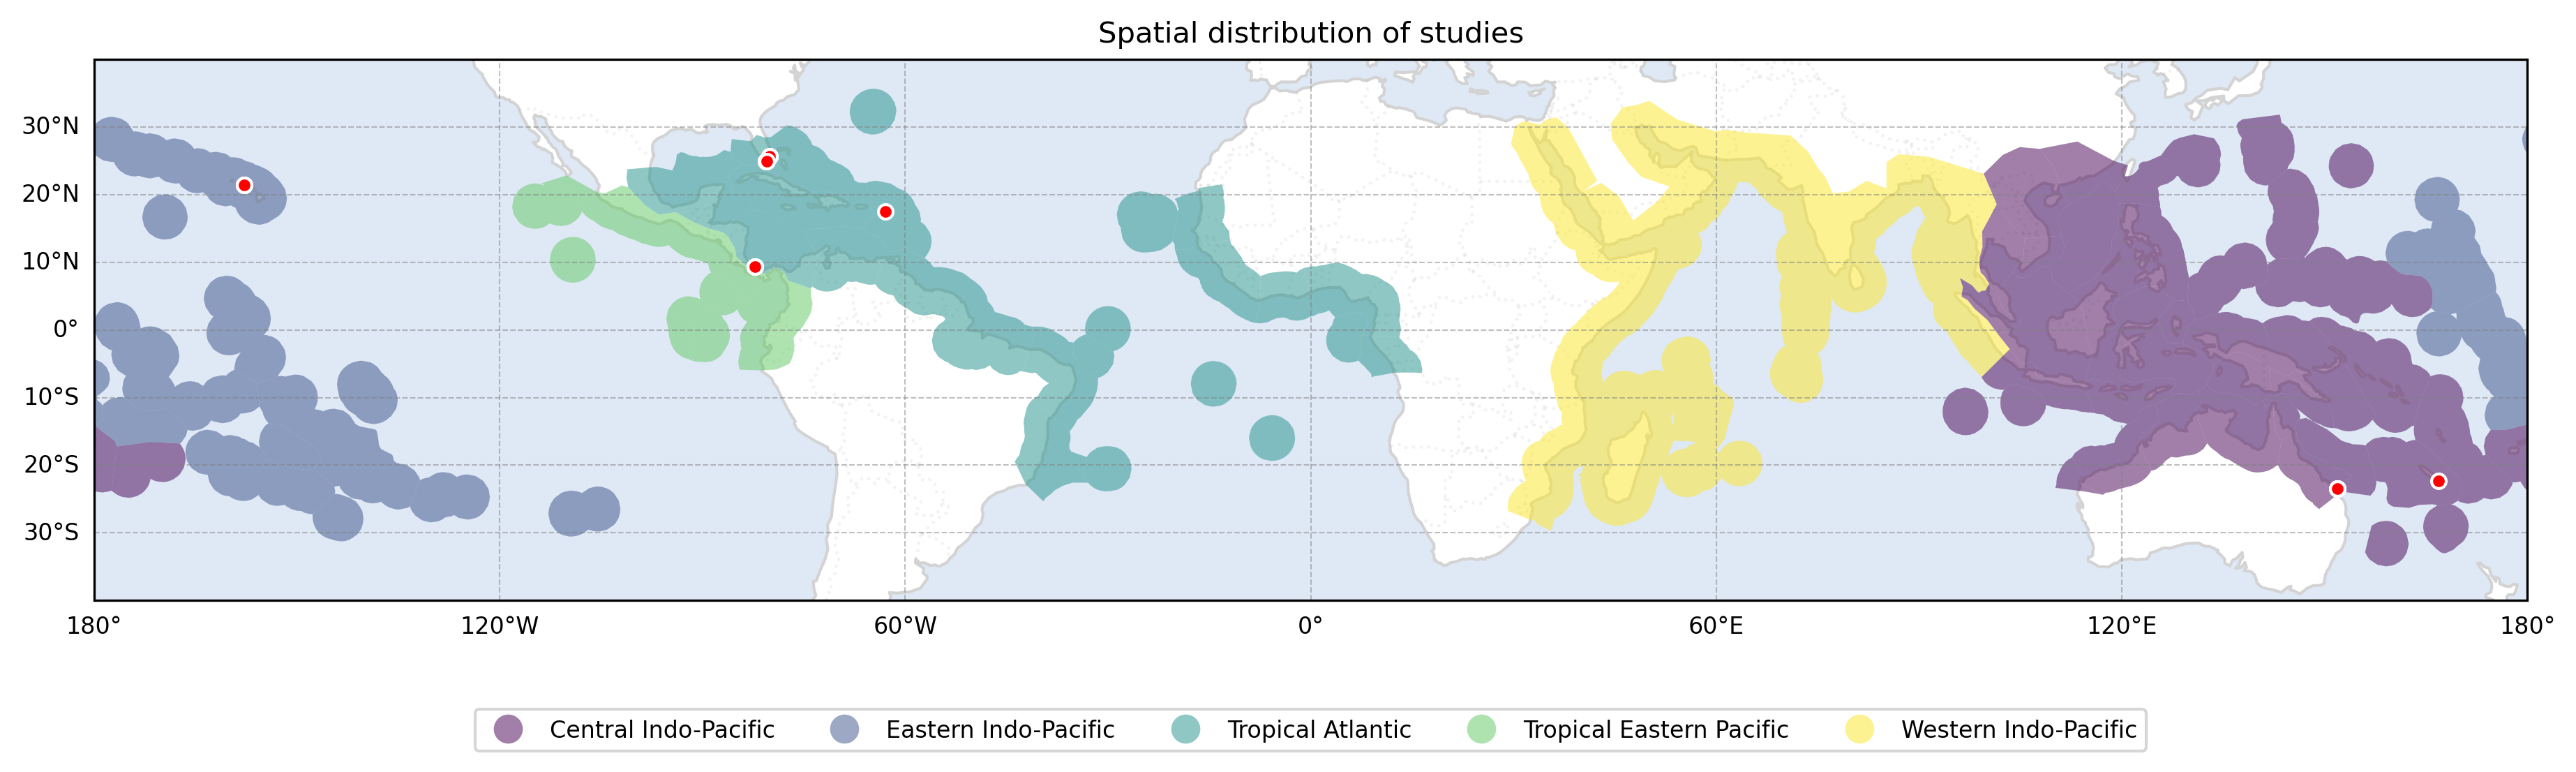

(<Figure size 4500x3000 with 1 Axes>,
 <GeoAxes: title={'center': 'Spatial distribution of studies'}>)

In [117]:
### visualise study distribution
plotting.plot_areas_with_study_locations(working_df.drop_duplicates('doi', keep='first'))

## Variable-calcification visualisations

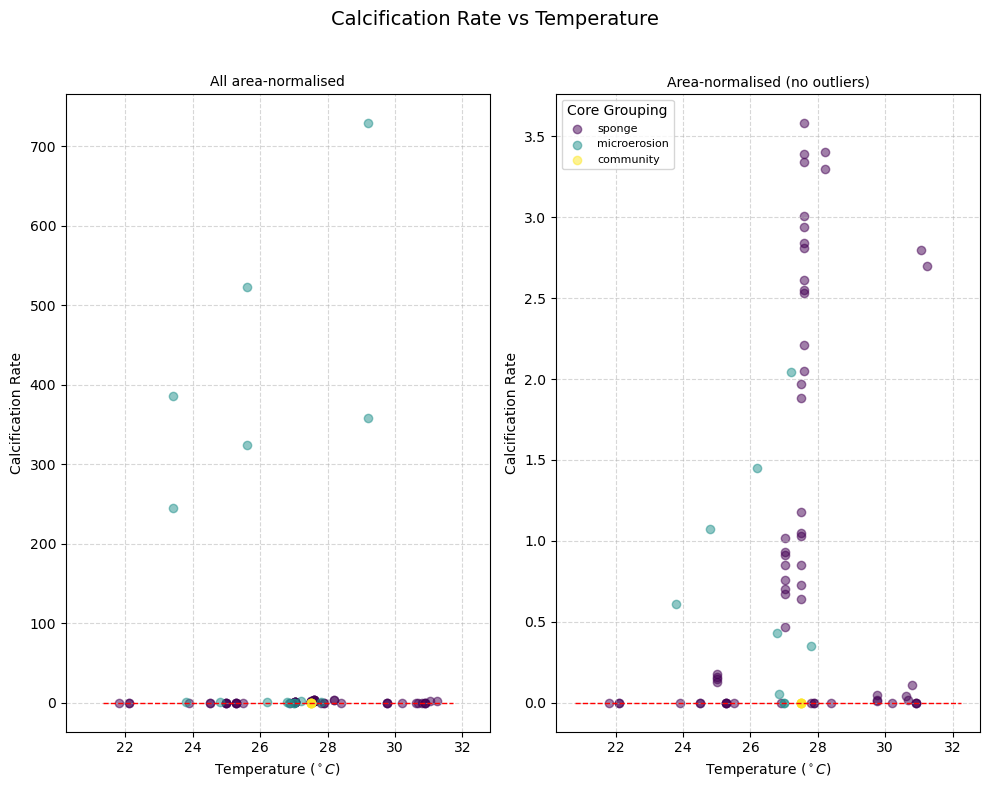

In [118]:
### naive plotting of calcification rates against absolute values of temperature
area_norm_df = working_df[working_df['st_calcification_unit'] == 'mgCaCO3 cm-2d-1'].copy()

# TODO: these currently assigned by sight due to large inherent variance
area_norm_no_outliers_df = area_norm_df[
    (area_norm_df.st_calcification > -10) &
    (area_norm_df.st_calcification < 10)
]   

fig, axes = plt.subplots(1, 2, figsize=(10, 8), sharex=True)
group_color_map = {
    group: color
    for group, color in zip(
        area_norm_df['core_grouping'].dropna().unique(),
        plt.cm.viridis(np.linspace(0, 1, area_norm_df['core_grouping'].nunique()))
    )
}

plots = [
    (0, area_norm_df, 'All area-normalised'),
    (1, area_norm_no_outliers_df, 'Area-normalised (no outliers)'),
]

for col, df, title in plots:
    ax = axes[col]
    for group, color in group_color_map.items():
        subset = df[df['core_grouping'] == group]
        ax.scatter(subset['temp'], subset['st_calcification'], color=color, label=group, alpha=0.5)
    ax.set_title(title, fontsize=10)
    ax.set_xlabel('Temperature ($^\\circ C$)')
    ax.set_ylabel('Calcification Rate')
    ax.grid(ls='--', alpha=0.5)
    ax.hlines(0, *ax.get_xlim(), color='red', linestyle='--', linewidth=1)
    if col == 1:
        ax.legend(title="Core Grouping", loc='upper left', fontsize=8)

fig.suptitle('Calcification Rate vs Temperature', fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle


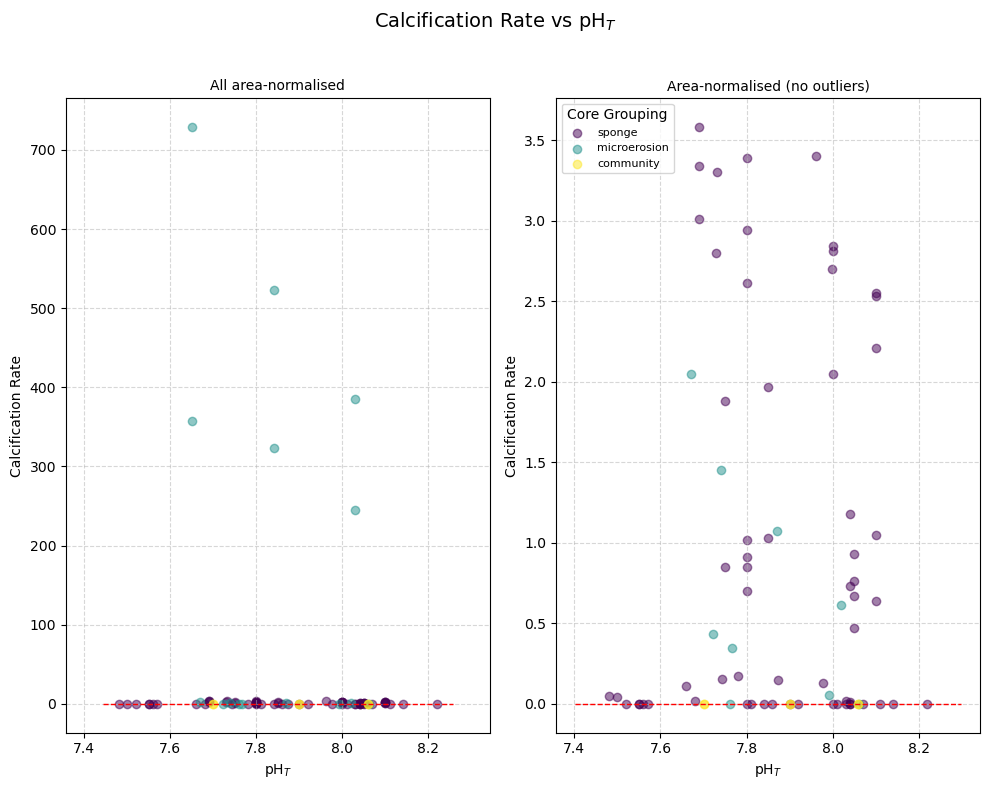

In [119]:
### naive plotting of calcification rates against absolute values of pH
### for two main unit subsets (mgCaCO3 cm-2d-1 and mgCaCO3 g-1d-1)

fig, axes = plt.subplots(1, 2, figsize=(10, 8), sharex=True)
group_color_map = {
    group: color
    for group, color in zip(
        area_norm_df['core_grouping'].dropna().unique(),
        plt.cm.viridis(np.linspace(0, 1, area_norm_df['core_grouping'].nunique()))
    )
}

plots = [
    (0, area_norm_df, 'All area-normalised'),
    (1, area_norm_no_outliers_df, 'Area-normalised (no outliers)'),
]

for col, df, title in plots:
    ax = axes[col]
    for group, color in group_color_map.items():
        subset = df[df['core_grouping'] == group]
        ax.scatter(subset['phtot'], subset['st_calcification'], color=color, label=group, alpha=0.5)
    ax.set_title(title, fontsize=10)
    ax.set_xlabel('pH$_T$')
    ax.set_ylabel('Calcification Rate')
    ax.grid(ls='--', alpha=0.5)
    ax.hlines(0, *ax.get_xlim(), color='red', linestyle='--', linewidth=1)
    if col == 1:
        ax.legend(title="Core Grouping", loc='upper left', fontsize=8)

fig.suptitle('Calcification Rate vs pH$_T$', fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle
plt.show()


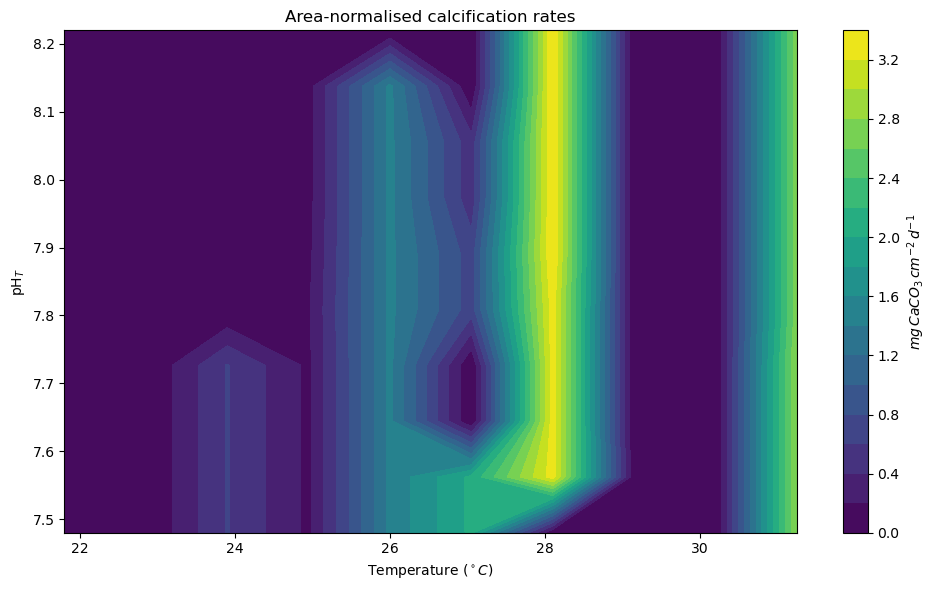

In [120]:
### contour plot of calcification rates against temperature and pH

fig, ax = plt.subplots(figsize=(10, 6), sharex=True)
npoints = 10

area_x = np.linspace(area_norm_no_outliers_df.temp.min(), area_norm_no_outliers_df.temp.max(), npoints)  # Temperature range
area_y = np.linspace(area_norm_no_outliers_df.phtot.min(), area_norm_no_outliers_df.phtot.max(), npoints)  # pH range

plotting.plot_contour(ax, area_x, area_y, area_norm_no_outliers_df, 'Area-normalised calcification rates', legend_label=r'$mg \, CaCO_3 \, cm^{-2} \, d^{-1}$')

plt.tight_layout()

## Effect sizes

First, an exploration of how treatments/effects are computed

In [ ]:
raw_cois = ['doi', 'species_types', 'temp', 'treatment_level_t', 'phtot', 'treatment_level_ph', 'calcification', 'treatment', 'irr']
study_cois = raw_cois + ['calcification', 'control_calcification', 'treatment_calcification']

study = working_df[working_df.doi == working_df.doi.unique()[1]]
study[raw_cois]

,doi,species_types,temp,treatment_level_t,phtot,treatment_level_ph,calcification,treatment,irr
4,10.3354/ab00527,Cliona orientalis,21.8,0,8.0,0,0.15,control,NaN
5,10.3354/ab00527,Cliona orientalis,22.1,0,7.8,1,0.37,phtot,NaN
6,10.3354/ab00527,Cliona orientalis,22.1,0,7.52,2,1.04,phtot,NaN
7,10.3354/ab00527,Cliona orientalis,23.9,1,8.04,0,0.21,temp,NaN
8,10.3354/ab00527,Cliona orientalis,24.5,2,7.84,1,0.51,temp_phtot,NaN
9,10.3354/ab00527,Cliona orientalis,24.5,2,7.57,2,1.09,temp_phtot,NaN
10,10.3354/ab00527,Cliona orientalis,27.8,3,8.03,0,0.09,temp,NaN
11,10.3354/ab00527,Cliona orientalis,27.9,3,7.81,1,0.25,temp_phtot,NaN
12,10.3354/ab00527,Cliona orientalis,27.9,3,7.55,2,0.95,temp_phtot,NaN
13,10.3354/ab00527,Cliona orientalis,30.9,4,8.07,0,0.13,temp,NaN


In [148]:
analysis.calculate_effect_for_df(study).reset_index(drop=True)[study_cois + ['treatment_val', 'control_temp', 'treatment_temp', 'control_phtot', 'treatment_phtot']].head(10)

  0%|          | 0/1 [00:00<?, ?it/s]

,doi,species_types,temp,treatment_level_t,phtot,treatment_level_ph,calcification,treatment,calcification,control_calcification,treatment_calcification,treatment_val,control_temp,treatment_temp,control_phtot,treatment_phtot
0,10.3354/ab00527,Cliona orientalis,22.1,0,7.8,1,0.37,phtot,0.37,0.15,0.37,7.8,21.8,22.1,8.0,7.8
1,10.3354/ab00527,Cliona orientalis,22.1,0,7.52,2,1.04,phtot,1.04,0.15,1.04,7.52,21.8,22.1,8.0,7.52
2,10.3354/ab00527,Cliona orientalis,23.9,1,8.04,0,0.21,temp,0.21,0.15,0.21,23.9,21.8,23.9,8.0,8.04
3,10.3354/ab00527,Cliona orientalis,27.8,3,8.03,0,0.09,temp,0.09,0.15,0.09,27.8,21.8,27.8,8.0,8.03
4,10.3354/ab00527,Cliona orientalis,30.9,4,8.07,0,0.13,temp,0.13,0.15,0.13,30.9,21.8,30.9,8.0,8.07
5,10.3354/ab00527,Cliona orientalis,30.9,4,7.92,0,0.28,temp,0.28,0.15,0.28,30.9,21.8,30.9,8.0,7.92
6,10.3354/ab00527,Cliona orientalis,24.5,2,7.84,1,0.51,temp_mv,0.51,0.37,0.51,7.84,22.1,24.5,7.8,7.84
7,10.3354/ab00527,Cliona orientalis,27.9,3,7.81,1,0.25,temp_mv,0.25,0.37,0.25,7.81,22.1,27.9,7.8,7.81
8,10.3354/ab00527,Cliona orientalis,24.5,2,7.57,2,1.09,temp_mv,1.09,1.04,1.09,7.57,22.1,24.5,7.52,7.57
9,10.3354/ab00527,Cliona orientalis,24.5,2,7.57,2,1.09,phtot_mv,1.09,0.51,1.09,7.57,24.5,24.5,7.84,7.57


In [142]:
### generating effect sizes
effects_df = analysis.calculate_effect_for_df(working_df).reset_index(drop=True)
# errors thrown up re no control data due to questionable studies (excluding explicitly adapted studies)
print(f'Shape of dataframe with effect sizes: {effects_df.shape}')
print(effects_df['treatment'].value_counts())
working_effects_df = effects_df.copy()
effect_sizes=['cohens_d', 'hedges_g', 'relative_calcification', 'absolute_calcification', 'st_relative_calcification', 'st_absolute_calcification']

  0%|          | 0/19 [00:00<?, ?it/s]

Missing data for effect size calculation. mu_t: 0.460, mu_c: 0.310, sd_t: nan, sd_c: nan, n_t: 9.000, n_c: 9.000 at 
[index 72 DOI 10.1029/2008GB003286]
10.1029/2008GB003286
Shape of dataframe with effect sizes: (54, 117)
treatment
phtot       31
temp_mv      9
temp         7
phtot_mv     7
Name: count, dtype: int64


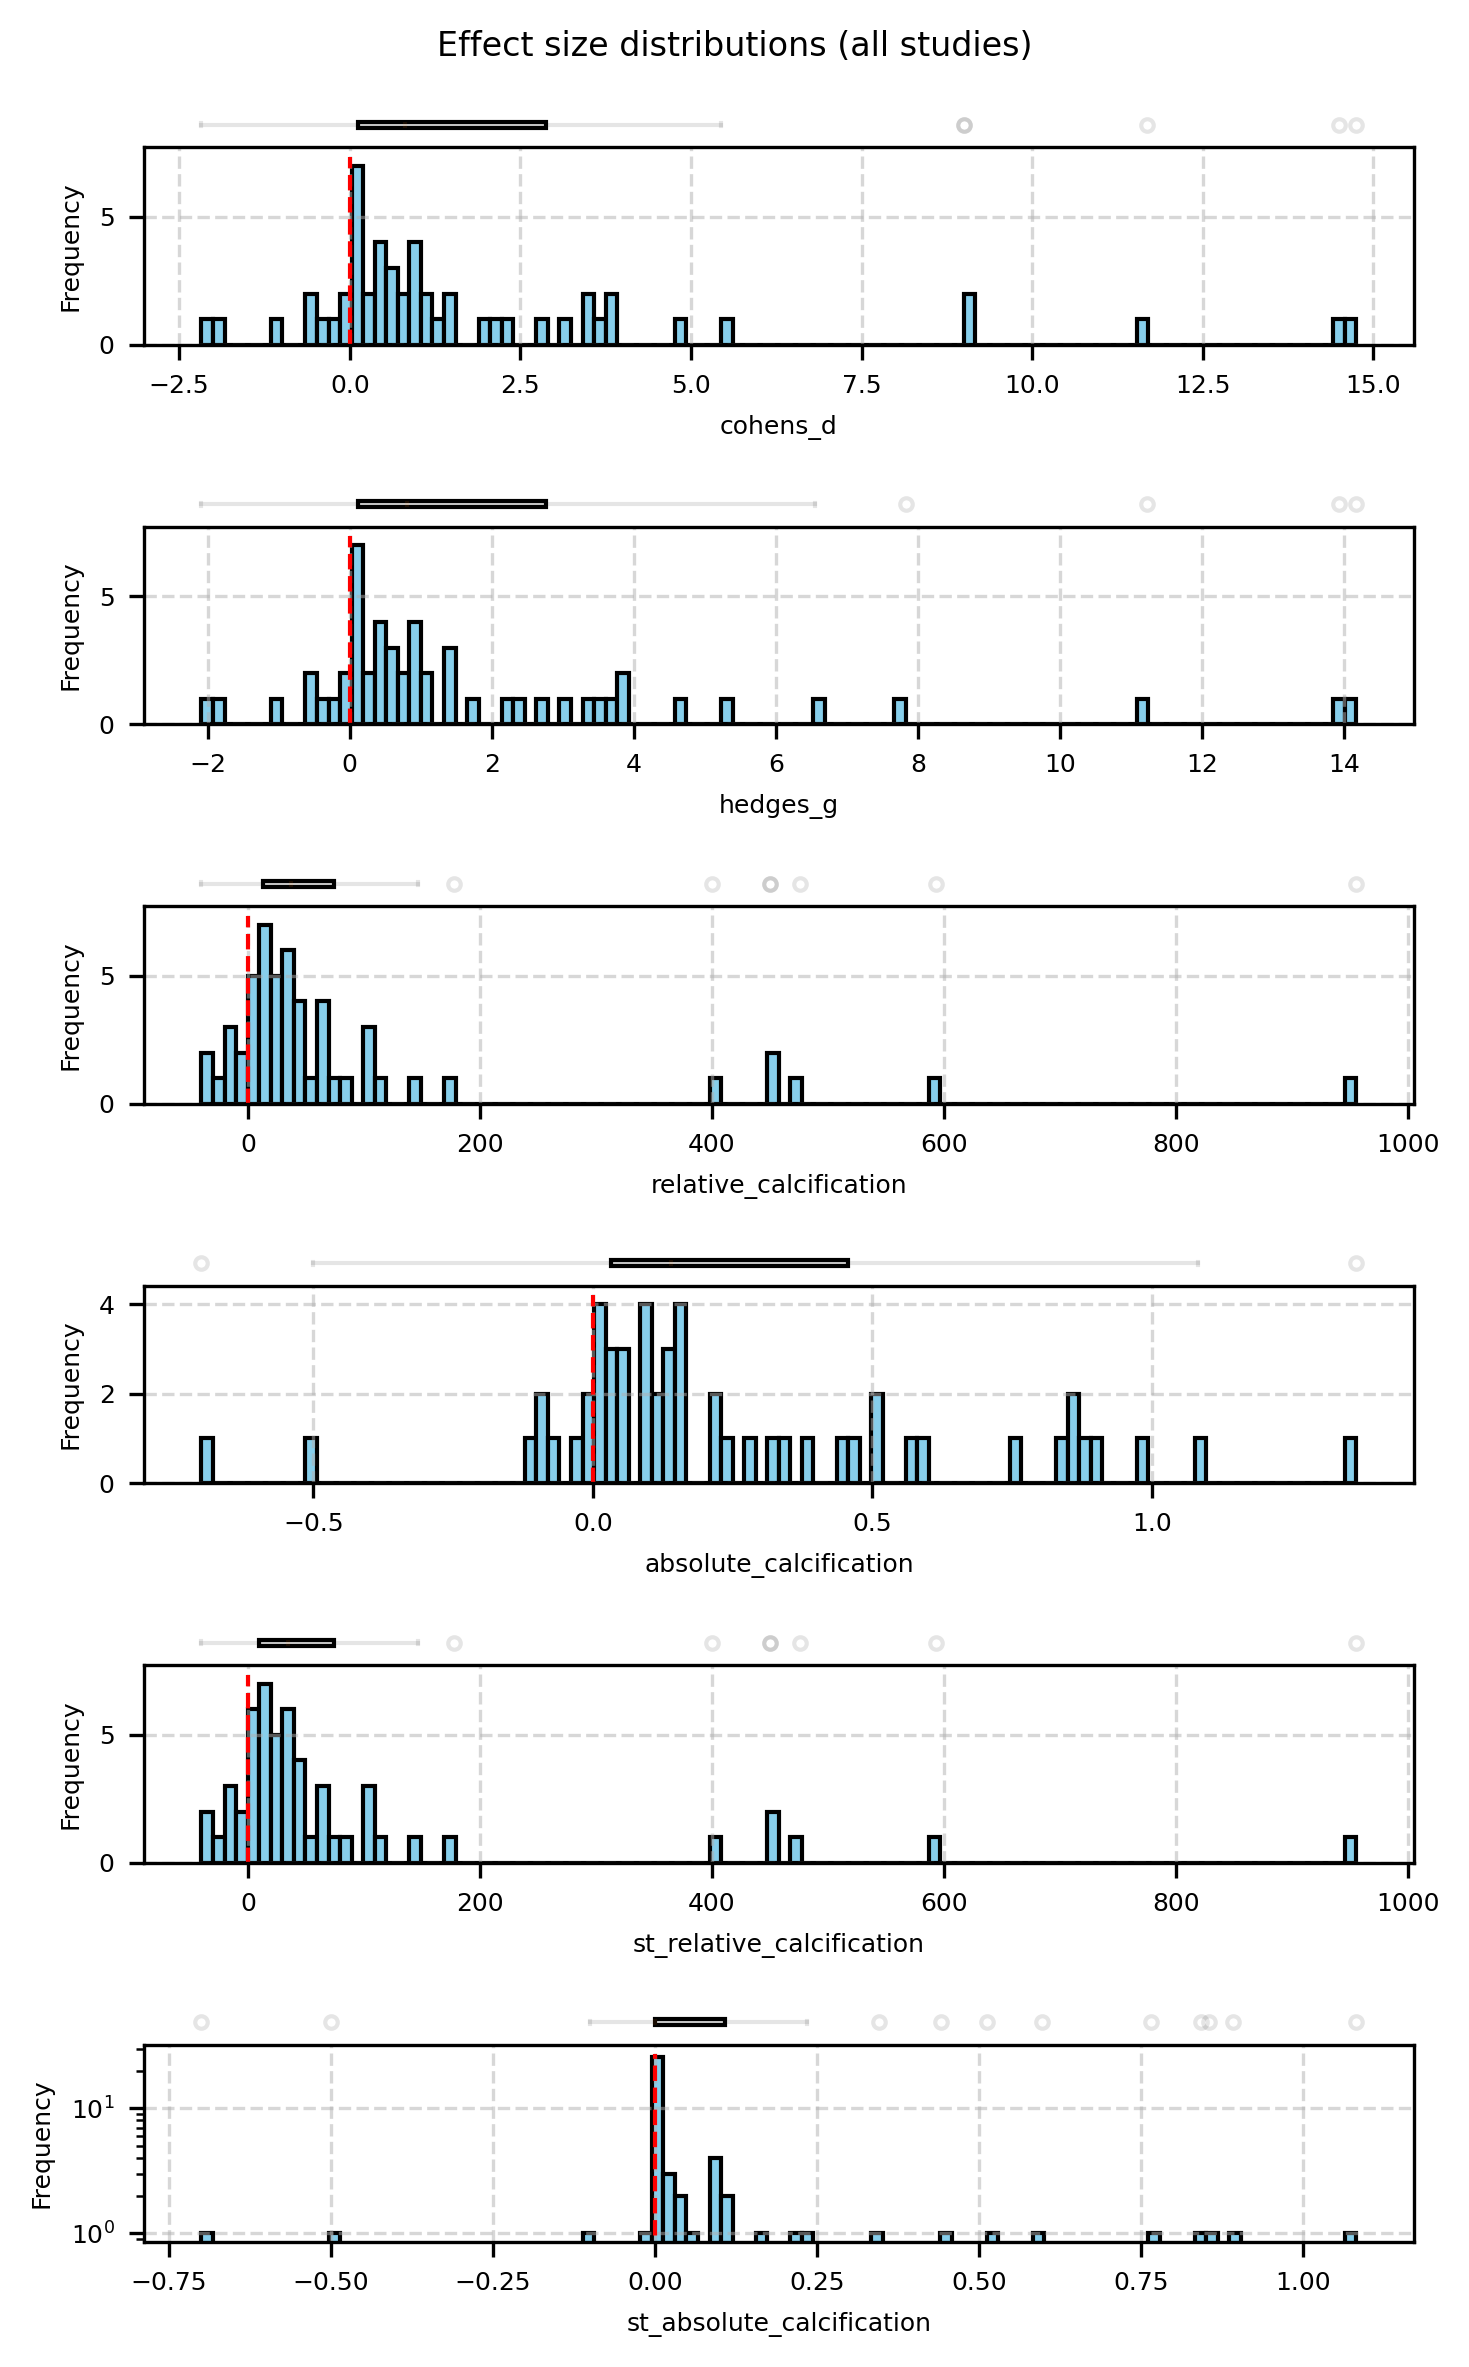

In [124]:
plotting.plot_effect_size_distributions(
    working_effects_df, title='Effect size distributions (all studies)',
)

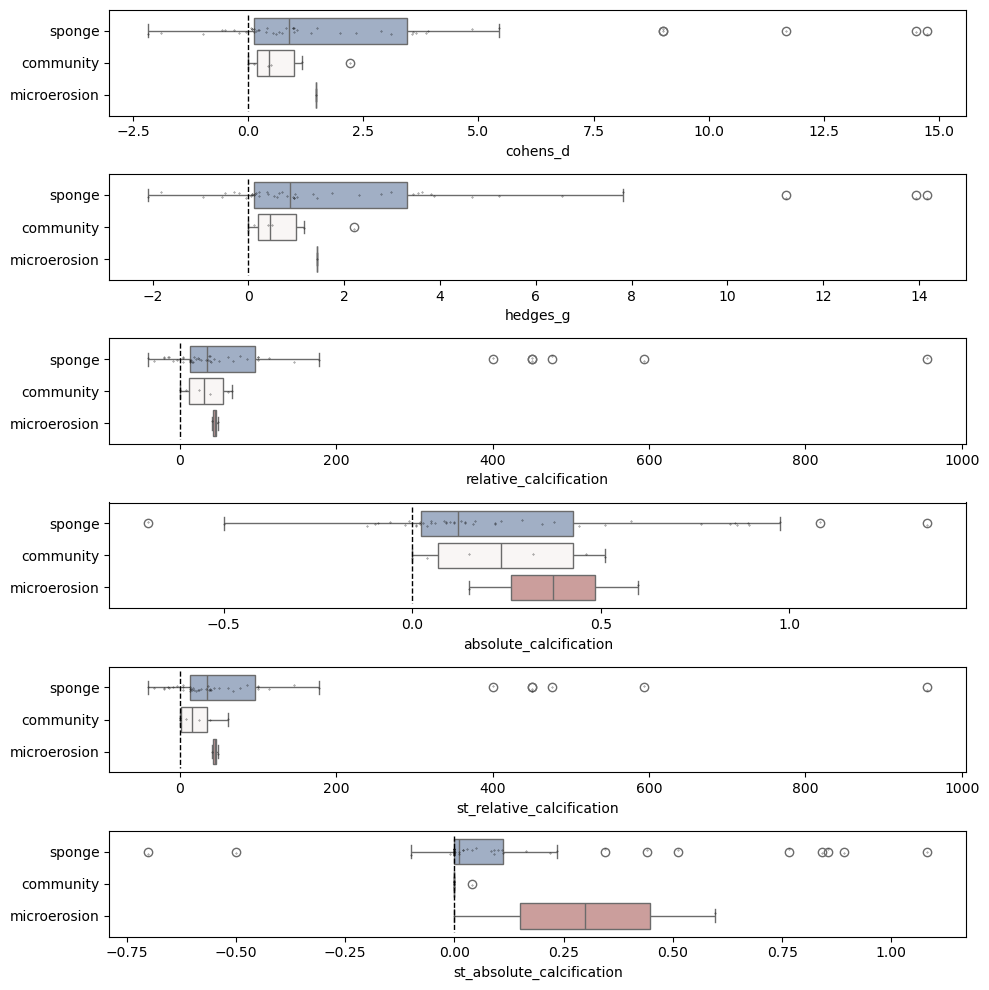

In [125]:
### break down effect size by core_grouping
fig, axes = plt.subplots(len(effect_sizes), 1, figsize=(10, 10), sharex=False)

for i, effect_size in enumerate(effect_sizes):
    # plot the effect sizes for each core grouping
    sns.boxplot(
        data=working_effects_df,
        x=effect_size,
        y='core_grouping',
        palette='vlag',
        hue='core_grouping',
        ax=axes[i],
    )
    sns.stripplot(
        data=working_effects_df,
        x=effect_size,
        y='core_grouping',
        ax=axes[i],
        alpha=0.3,
        marker='x',
        s=1,
        color='black',  # Ensure this is the desired color
        linewidth=1  # Optional: Add a line width for better visibility
    )
    axes[i].vlines(
        x=0,
        ymin=-0.5,
        ymax=len(working_effects_df['core_grouping'].unique()) - 0.5,
        color='black',
        linestyle='--',
        linewidth=1,
        zorder=10
    )
    axes[i].set_ylabel('')
plt.tight_layout()

Text(0.5, 1.0, 'Number of effect sizes per core grouping')

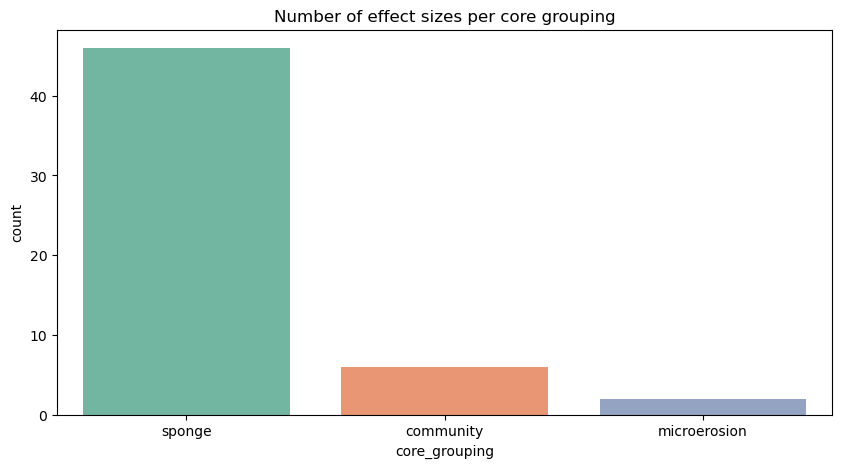

In [126]:
### visualise the number of effect sizes per core grouping
fig, ax = plt.subplots(figsize=(10, 5))
# order by number of effect sizes
count_order = working_effects_df['core_grouping'].value_counts().index
# plot the number of effect sizes per core grouping
sns.countplot(
    data=working_effects_df,
    x='core_grouping',
    order=count_order,
    palette='Set2',
    hue='core_grouping',
)
plt.title('Number of effect sizes per core grouping')

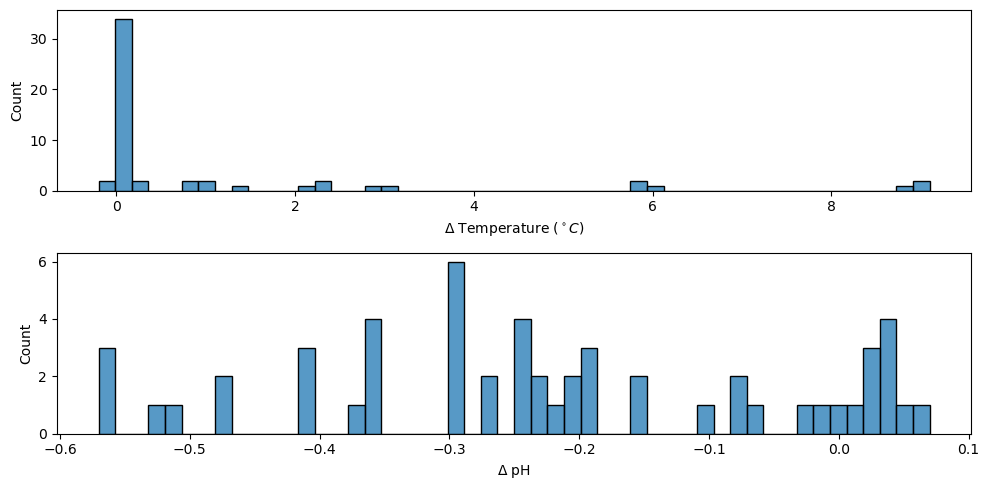

In [127]:
### plot distribution of delta ph and delta_t
fig, axes = plt.subplots(2, 1, figsize=(10, 5))
# Plot delta_t
sns.histplot(
    data=working_effects_df,
    x='delta_t',
    bins=50,
    ax=axes[0],
)
axes[0].set_xlabel('$\\Delta$ Temperature ($^\\circ C$)')
# Plot delta_pH
sns.histplot(
    data=working_effects_df,
    x='delta_ph',
    bins=50,
    ax=axes[1],
)
axes[1].set_xlabel('$\\Delta$ pH')
plt.tight_layout()

## Meta-regression

In [137]:
# set effect type for all proceeding cells
effect_type = "relative_calcification"

In [138]:
### run meta-analysis
basic_ph_model, basic_ph_model_summary, basic_ph_model_formula, ph_df = analysis.run_metafor_mv(
    working_effects_df,
    effect_type=effect_type,
    treatment='phtot',
)

basic_temp_model, basic_temp_model_summary, basic_temp_model_formula, temp_df = analysis.run_metafor_mv(
    working_effects_df,
    effect_type=effect_type,
    treatment='temp',
)


----- PROCESSING SUMMARY -----
Treatment:  phtot
Total samples in input data:  54
Total samples of relevant investigation:  31
Dropped due to NaN values in required columns: 1
Final sample count: 30 (24 rows dropped)

Removed 2 outlier(s) (from 30 samples) based on Cook's distance threshold of 0.53
Using formula relative_calcification ~ delta_ph - 1

Running metafor model...
Model fitting complete.

----- PROCESSING SUMMARY -----
Treatment:  temp
Total samples in input data:  54
Total samples of relevant investigation:  16
Dropped due to NaN values in required columns: 0
Final sample count: 16 (38 rows dropped)

Removed 1 outlier(s) (from 16 samples) based on Cook's distance threshold of 0.76
Using formula relative_calcification ~ delta_t - 1

Running metafor model...
Model fitting complete.


In [139]:
print(basic_ph_model_summary)


Multivariate Meta-Analysis Model (k = 28; method: REML)

   logLik   Deviance        AIC        BIC       AICc   
-132.1339   264.2677   270.2677   274.1552   271.3112   

Variance Components:

              estim     sqrt  nlvls  fixed           factor 
sigma^2.1  684.6250  26.1653     10     no     original_doi 
sigma^2.2  435.7539  20.8747     28     no  original_doi/ID 

Test for Residual Heterogeneity:
QE(df = 27) = 585.4772, p-val < .0001

Model Results:

           estimate       se     zval    pval      ci.lb     ci.ub      
delta_ph  -108.2620  28.8918  -3.7472  0.0002  -164.8889  -51.6351  *** 

---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Extra argument ('useS4') disregarded. 



(-1, 0)
(0, 11)


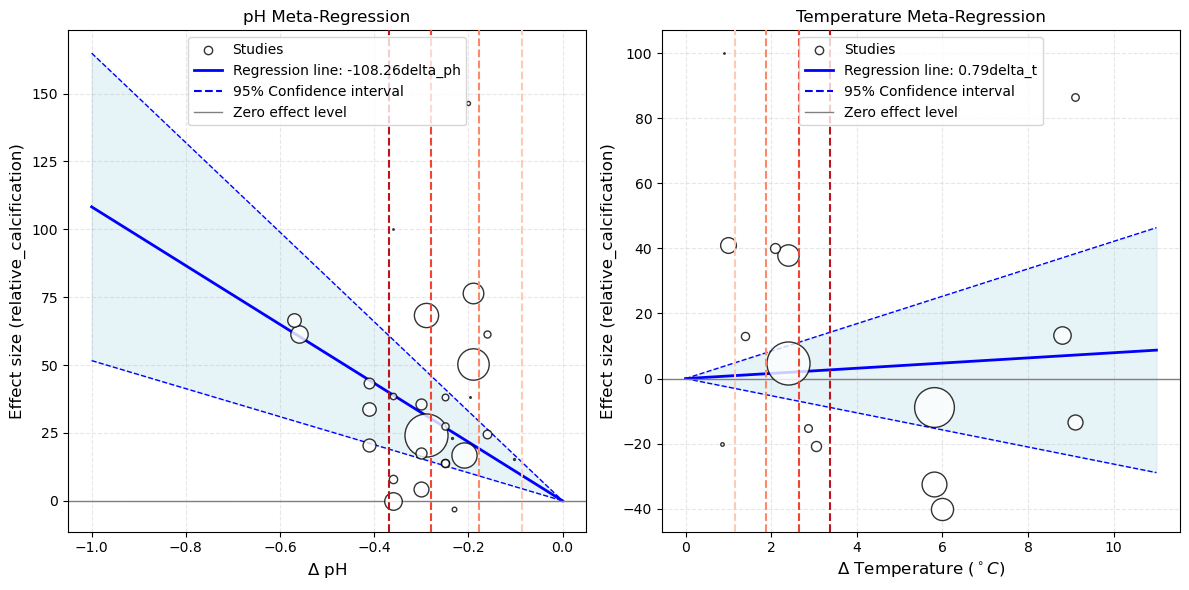

In [140]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=False)

# Plot the pH meta-regression
var = 'phtot'
xlab, xlim, predlim, scenario_var = plotting.set_up_regression_plot(var)
reg_fig, ph_reg_ax = plotting.meta_regplot(
    model=basic_ph_model,
    model_comps = analysis.get_formula_components(basic_ph_model_formula),
    x_mod = 'delta_ph',
    pi=False,
    xlim=None,
    xlab=xlab,
    predlim=xlim,
    ax=axes[0],
    future_global_anomaly_df=future_global_anomaly_df,
    scenario_var=scenario_var,
)
axes[0].set_title("pH Meta-Regression")
plotting.add_climatology_lines_to_plot(ph_reg_ax, future_global_anomaly_df, scenario_var, xlim)

# Plot the temperature meta-regression
var = 'temp'
xlab, xlim, predlim, scenario_var = plotting.set_up_regression_plot(var)
reg_fig, temp_reg_ax = plotting.meta_regplot(
    model=basic_temp_model,
    model_comps = analysis.get_formula_components(basic_temp_model_formula),
    x_mod = 'delta_t',
    pi=False,
    xlim=None,
    xlab=xlab,
    predlim=xlim,
    ax=axes[1],
)
plotting.add_climatology_lines_to_plot(temp_reg_ax, future_global_anomaly_df, scenario_var, xlim)
axes[1].set_title("Temperature Meta-Regression")

plt.tight_layout()
plt.show()